<h3>The user behavior can be analyzed through the similarities in the cluster to improve and efficient planning and development of this existing gas supply system. Further, the consumption variance was used as an indicator of behavior variability or customers’ behavior changes.</h3>

In [13]:
import numpy as np
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from pathlib import Path
import timeit
import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pylab as pl
from sklearn.decomposition import PCA
from IPython.display import HTML

<h3>Clustering is a collection of same group similar or data objects or in other groups.Its also finding the dissimilar to the data objects in other groups.In cluster analysis, the main objective is to find similarities between data objects with the help of specific characteristics found in the data and grouping these similar data objects into clusters. In our project, the following features and their respective standard deviation will be examined in the folloing clustering discussion.</h3>

In [14]:
s = """<table>
<tr>
<th>Features</th>
<th>Discription</th>
</tr>
<tr>
<td>Total consumption</td>
<td>Total consumed power during period of the study</td>
</tr>
<tr>
<td>Morning consumtption</td>
<td>The consumption observed from 06:00 - 09:00</td>
</tr>
<tr>
<td>Noon consumtption</td>
<td>The consumption observed from 11:00 - 14:00</td>
</tr>
<tr>
<td>Night consumtption</td>
<td>The consumption observed from 17:00 - 20:00</td>
</tr>
</table>"""
h = HTML(s)
display(h)

Features,Discription
Total consumption,Total consumed power during period of the study
Morning consumtption,The consumption observed from 06:00 - 09:00
Noon consumtption,The consumption observed from 11:00 - 14:00
Night consumtption,The consumption observed from 17:00 - 20:00


In [15]:
path = str(Path().resolve().parent)+'\csv'
df = pd.read_csv(path+"/hourly_consumption.csv")

df.localminute = df.localminute.str.slice(0,19)
df.localminute = pd.to_datetime(df.localminute, infer_datetime_format = True, 
                                      format = "%Y/%m/%d %I:%M:%S %p");
headers = ["dataid", "totoalConsumption", "morningMean", "morningSTD", "noonMean",
          "noonSTD", "nightMean", "nightSTD"]
df.localminute = df.localminute.map(lambda x:x.replace(minute=0, second=0));
currentID = df.iloc[0]['dataid']
baseTime = df.iloc[0]['localminute'] 
featuresList = []
morningConsumption = []
noonConsumption = []
nightConsumption = []
totoalConsumption = 0
currentMorning = 0
currentNoon = 0
currentNight = 0
prevDay = 0

In [16]:
# Feature Extraction 
for row in df.itertuples():
    time_diff = str(row.localminute - baseTime)
    hrs_diff = int(time_diff.split(" ")[2][:2])
    day_diff = int((time_diff.split(" ")[0]))
    if (day_diff != prevDay):
        morningConsumption.append(currentMorning)
        noonConsumption.append(currentNoon)
        nightConsumption.append(currentNight)
        prevDay = day_diff
        currentMorning = 0
        currentNoon = 0
        currentNight = 0
        
    if (currentID != row.dataid):
        features = []
        morningMean = np.mean(morningConsumption)
        morningSTD = np.std(morningConsumption)
        noonMean = np.mean(noonConsumption)
        noonSTD = np.std(noonConsumption)
        nightMean = np.mean(nightConsumption)
        nightSTD = np.std(nightConsumption)
        features.append(currentID)
        features.append(totoalConsumption)
        features.append(morningMean)
        features.append(morningSTD)
        features.append(noonMean)
        features.append(noonSTD)
        features.append(nightMean)
        features.append(nightSTD)
        featuresList.append(features)
        
        morningConsumption = []
        noonConsumption = []
        nightConsumption = []
        totoalConsumption = 0
        currentID = row.dataid
    
    totoalConsumption = totoalConsumption + int(row.meter_value)
    if (hrs_diff >= 6 and hrs_diff < 9):
        currentMorning = currentMorning + int(row.meter_value)
    elif (hrs_diff >= 11 and hrs_diff < 14):
        currentNoon = currentNoon + int(row.meter_value)
    elif (hrs_diff >= 17 and hrs_diff < 20):
        currentNight = currentNight + int(row.meter_value)

morningConsumption.append(currentMorning)
noonConsumption.append(currentNoon)
nightConsumption.append(currentNight)
morningMean = np.mean(morningConsumption)
morningSTD = np.std(morningConsumption)
noonMean = np.mean(noonConsumption)
noonSTD = np.std(noonConsumption)
nightMean = np.mean(nightConsumption)
nightSTD = np.std(nightConsumption)
features = []

features.append(currentID)
features.append(totoalConsumption)
features.append(morningMean)
features.append(morningSTD)
features.append(noonMean)
features.append(noonSTD)
features.append(nightMean)
features.append(nightSTD)
featuresList.append(features)

featureFrame = pd.DataFrame(featuresList)
featureFrame.to_csv(path + '/reading_features.csv', header=headers, index=None)

<h3>K-medoids clustering selects the most centrally located data points within clusters as cluster centers called medoids and returns the number of clustering as required.</h3>

In [17]:
df = pd.read_csv(path+"/reading_features.csv")
featureNames = ["totoalConsumption", "morningMean", "noonMean", "nightMean"]
kmeans = KMeans(n_clusters=3).fit(df[featureNames])
df.insert(loc=0, column="classification", value=kmeans.labels_)
df.to_csv(path + '/reading_features_classification.csv', index=None)

Text(0,0.5,'Morning Average Consumption')

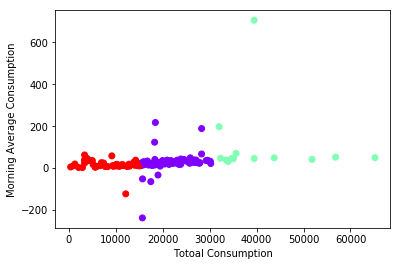

In [18]:
df_array = df.values
plt.scatter(df_array[:,2],df_array[:,3], c=kmeans.labels_, cmap='rainbow')  
plt.xlabel('Totoal Consumption')
plt.ylabel('Morning Average Consumption')

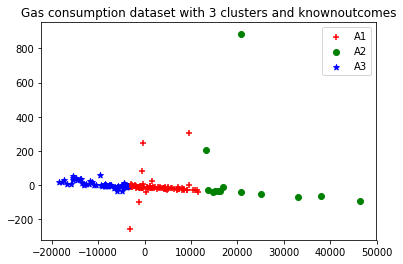

In [19]:
pca = PCA(n_components=2).fit(df[featureNames])
pca_2d = pca.transform(df[featureNames])
for i in range(0, pca_2d.shape[0]):
    if df.classification[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif df.classification[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
    elif df.classification[i] == 2:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
pl.legend([c1, c2, c3], ['A1', 'A2','A3'])
pl.title('Gas consumption dataset with 3 clusters and knownoutcomes')
pl.show()